In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import sys
import os
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator
from pprint import pprint
tool_dir0 = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/ESMF_profiling'
sys.path.append(tool_dir0)
from esmf_related_functions import _read_ryaml, _expt_fullname, _extract_ntasks_values, _extract_restart_stop_values, ideal_line1, ideal_line2, ideal_line3, update_ideal_ps, ideal_points_based_on_dataset, output_eff_indices, group_lists
from esmfFileParser import collect_runtime_tot
from collections import defaultdict
tool_dir = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/om3-utils'
sys.path.append(tool_dir)
from om3utils.nuopc_config import read_nuopc_config

In [9]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.max_colwidth', None)

In [10]:
pics_folder = "esmf-profiling"
pics_folder = os.path.join(tool_dir0, pics_folder)
os.makedirs(pics_folder, exist_ok=True)

In [11]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yaml_input = os.path.join(expts_manager_path, 'Expts_manager-1deg-scaling_performance_real_ww3_cpl_3600.yaml')
yamlfile_path = os.path.join(tool_dir,yaml_input)
yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
esmf_expt_dir1 = yaml_input['namelists']['cross_block1']['cross_block1_dirs']
esmf_expt_dirs = list(esmf_expt_dir1)
MOM_full_paths = [os.path.join(expts_manager_path, test_rel_path, esmf_expt_dir) for esmf_expt_dir in  esmf_expt_dirs]
xxx = '000'
ESMF_path = [f"{MOM_full_path}/archive/output{xxx}" for MOM_full_path in MOM_full_paths]
ncpus_list_combo1 = yaml_input['namelists']['cross_block1']['nuopc.runconfig']['PELAYOUT_attributes_combo']
expt_names1 = _expt_fullname(ncpus_list_combo1)
clock1_list_combo1 = yaml_input['namelists']['cross_block1']['nuopc.runconfig']['CLOCK_attributes_combo']
clock1 = _expt_fullname(clock1_list_combo1)
pprint(ESMF_path)
pprint(expt_names1)
# pprint(clock1)

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_1_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_2_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_3_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_4_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_5_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_6_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/prod

In [12]:
MOM_full_paths = []
for f in os.listdir(os.path.join(expts_manager_path, test_rel_path)):
    if f.startswith('pt'):
        MOM_full_path = os.path.join(expts_manager_path, test_rel_path, f)
        MOM_full_paths.append(MOM_full_path)
MOM_full_paths.sort()
MOM_full_paths = [
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_1',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_2',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_3',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_4',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_5',
]
xxx = '000'
ESMF_paths = [f"{MOM_full_path}/archive/output{xxx}" for MOM_full_path in MOM_full_paths]
pprint(ESMF_paths)
file_read = [read_nuopc_config(os.path.join(ESMF_path, 'nuopc.runconfig')) for ESMF_path in ESMF_paths]
task_values = [f['PELAYOUT_attributes'] for f in file_read]
task_values_eff_indices = range(len(task_values))

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_1/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_2/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurrent2_3/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600/pt_8_test_wav_concurr

In [6]:
date_values = _extract_restart_stop_values(clock1)


In [13]:
regionNames = [
    '[ESMF]',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[WAV] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7/MED: (med_map_mod: RouteHandles_init)',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ATM] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ROF] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ICE] IPDv01p3',
]

In [14]:
%%time
dt=3600
num_baroclinic_ts = 31*24*3600/dt
print(num_baroclinic_ts)
profile_prefix='ESMF_Profile'
# ESMF_Profile.xxx    : (0. count, 1. total, 2. self_time, 3. mean    , 4. min_time, 5. max_time           )
# ESMF_Profile.summary: (0. count, 1. PETs , 2. mean     , 3. min_time, 4. max_time, 5. min_PET, 6. max_PET)
esmf_summary = True
index = 2
runtime_tot = collect_runtime_tot(ESMF_path, regionNames=regionNames, profile_prefix=profile_prefix, esmf_summary=esmf_summary, index=index)
for tmp in runtime_tot:
    for k,v in tmp.items():
        tmp[k] = v/num_baroclinic_ts

744.0
CPU times: user 42.9 ms, sys: 16.1 ms, total: 59.1 ms
Wall time: 215 ms


In [15]:
len(runtime_tot)

8

In [13]:
user_defined_ocn_ice_tot = 360#384
task_values, task_values_eff_indices = output_eff_indices(expt_names1, user_defined_ocn_ice_tot, False)
task_values
# task_values = _extract_ntasks_values(expt_names1)
# task_values_eff = []
# task_values_eff_indices = []
# for indx, i in enumerate(task_values):
#     if i['ocn_ntasks']+i['ice_ntasks']<= 384:
#         task_values_eff.append(i)
#         task_values_eff_indices.append(indx)

[{'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 48,
  'rof_ntasks': 24,
  'wav_ntasks': 24,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 48,
  'rof_ntasks': 24,
  'wav_ntasks': 48,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 96,
  'rof_ntasks': 24,
  'wav_ntasks': 96,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 144,
  'rof_ntasks': 24,
  'wav_ntasks': 144,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 192,
  'rof_ntasks': 24,
  'wav_ntasks': 192,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_ntasks': 24,
  'ice_ntasks': 48,
  'ocn_ntasks': 240,
  'ocn_rootpe': 240,
  'rof_ntasks': 24,
  'wav_ntasks': 240,
  'wav_rootpe': 0},
 {'atm_ntasks': 24,
  'cpl_n

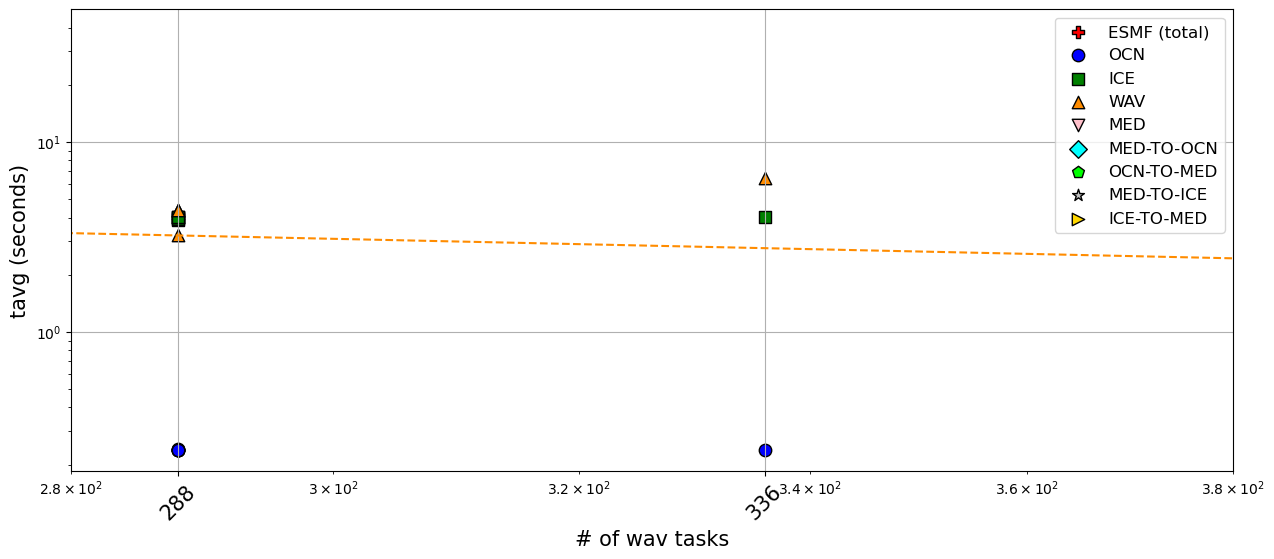

In [28]:
label_fontsize = 15
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (15, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ocn_ntasks = [i['wav_ntasks'] for i in task_values]
select_index = task_values_eff_indices
regions_index = [0,1,2,5,11,6,7,8,9]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*','>','<']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "WAV",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [1,2,3]
ideal_regions_index = [3]
key_x = 'wav_ntasks'
x_range = [14, 400]
start_index = 1
incre=12
for i in select_index:
    plot_x_values = task_values[i][key_x]
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot, x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

title = 'mom6-cice6'
axes[0].legend(handles=black_marker_legend, loc='upper right', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ocn_ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('# of wav tasks', fontsize=label_fontsize)
axes[0].set_ylabel('tavg (seconds)', fontsize=label_fontsize)
# axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range
axes[0].set_xlim(xlims)
axes[0].set_xlim([280,380])
plt.show()

[48, 288, 144, 96, 48, 24, 12]
4.024731317204301
3.994528091397849
3.8813127688172044
3.9291678763440863
4.032722311827957
4.008770430107527
4.014349731182795


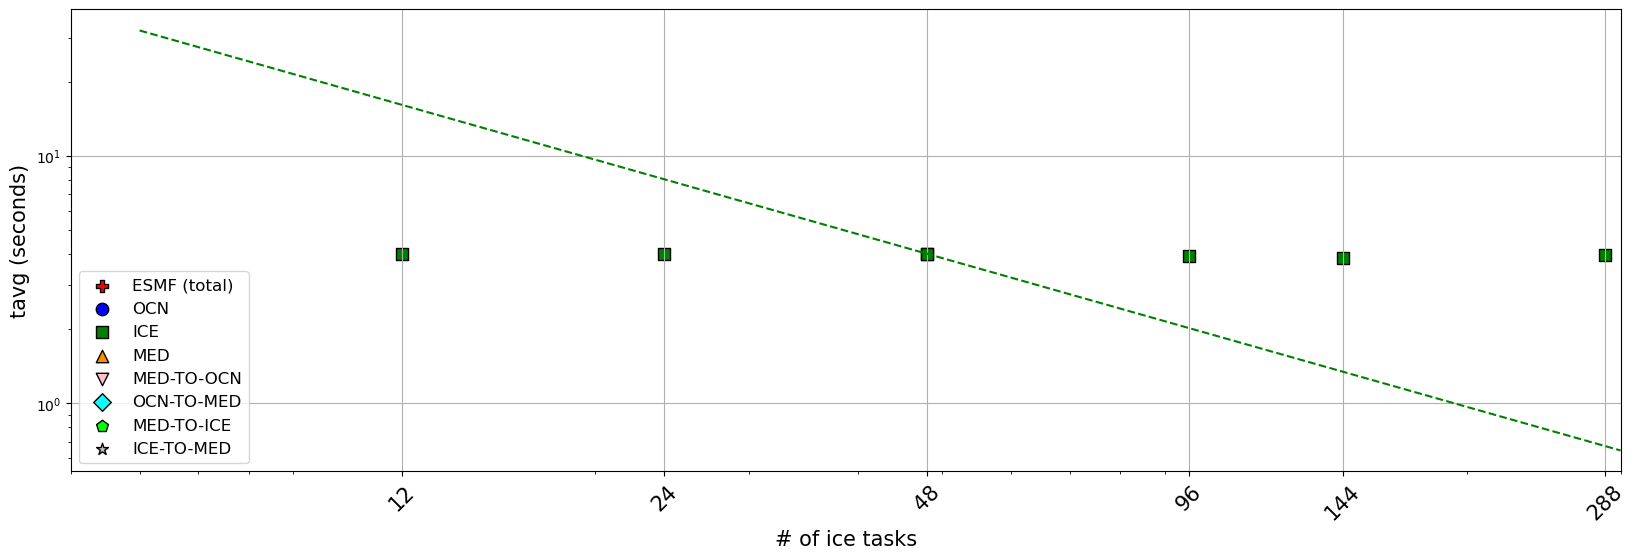

In [29]:
label_fontsize = 15
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (20, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ntasks = [i['ice_ntasks'] for i in task_values]
print(ntasks)
select_index = task_values_eff_indices
regions_index = [0,1,2,11,5,6,7,8]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [2]
ideal_regions_index = [2]
key_x = 'ice_ntasks'
x_range = [5, 300]
start_index = 0
incre=2
for i in select_index:
    plot_x_values = task_values[i][key_x]
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot,x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

title = 'mom6-cice6'
axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('# of ice tasks', fontsize=label_fontsize)
axes[0].set_ylabel('tavg (seconds)', fontsize=label_fontsize)
# axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range
axes[0].set_xlim(xlims)
plt.show()

In [94]:
grouped_values = group_lists(task_values, runtime_tot, task_values_eff_indices)

In [14]:
#grouped_values

1
group total ncpus: 48, group ocn_ncpus: [24, 32, 36, 40, 42], group ice_ncpus: [24, 16, 12, 8, 6]
ratios: (1, 2, 3, 5, 7)
selected_runtimes: [1588.4619, 1205.9209, 1110.0312, 1020.2477, 989.1034]
selected_runtimes: [1537.081, 1149.7709, 1053.1584, 959.5528, 927.4659]
selected_runtimes: [84.1914, 132.5102, 165.2044, 233.177, 282.9228]
start_x2: 24.0
select_rts2: 84.1914
x_range: [6.0, 24.0]
ideal_points-ice: [(6.0, 336.7656), (7.0, 288.6562285714286), (8.0, 252.57420000000002), (9.0, 224.5104), (10.0, 202.05936), (11.0, 183.69032727272727), (12.0, 168.3828), (13.0, 155.43027692307695), (14.0, 144.3281142857143), (15.0, 134.70624), (16.0, 126.28710000000001), (17.0, 118.85844705882354), (18.0, 112.2552), (19.0, 106.34703157894737), (20.0, 101.02968), (21.0, 96.21874285714286), (22.0, 91.84516363636364), (23.0, 87.85189565217391), (24.0, 84.1914)]
update_ideal_points: [(7, 336.7656), (5, 252.57420000000002), (3, 168.3828), (2, 126.28710000000001), (1, 84.1914)]
2
group total ncpus: 96, 

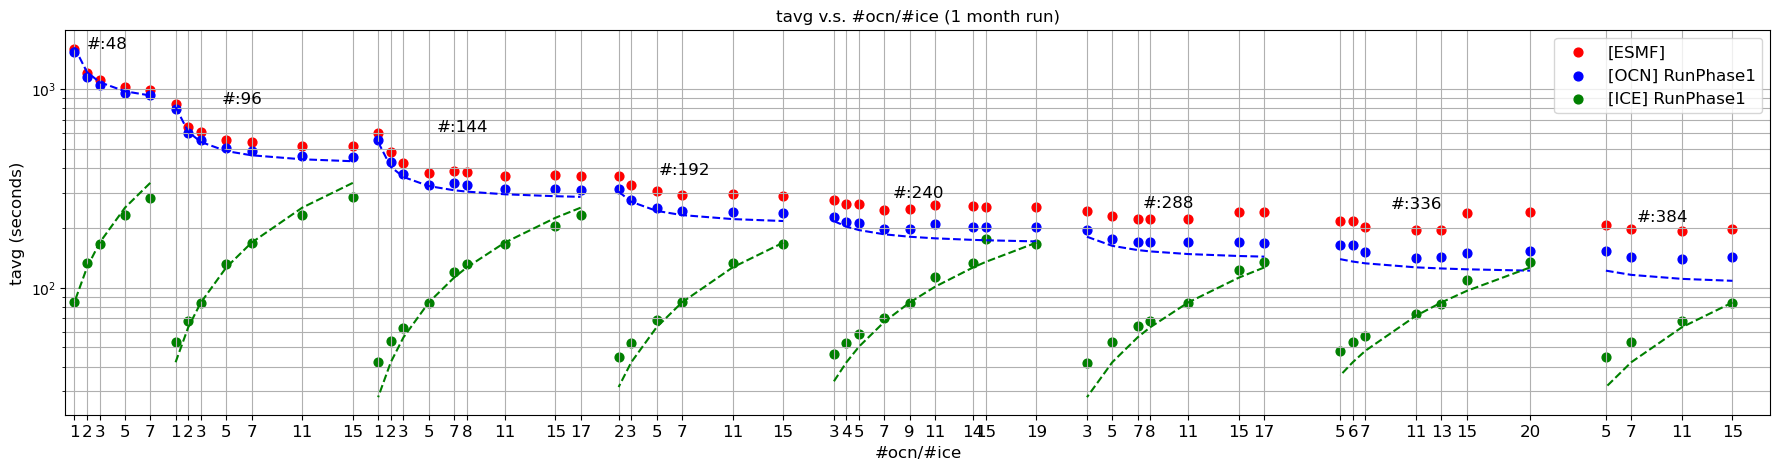

In [98]:
import matplotlib.pyplot as plt
import itertools
direction = 'both'
incre = 1
labelfontsize = 12
colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

# Function to plot scatter plots and label each group once for all runtime types
def plot_grouped_scatter(grouped_values, runtime_keys):
    # Initialize the figure
    plt.figure(figsize=(22, 5))
    shift_factor = 0
    xticks = []
    xlabels = []
    plotted_labels = set()  # Track which runtime labels have been plotted to avoid duplicates
    # Define a color cycle, enough colors for each runtime key
    # color_cycle = itertools.cycle(plt.cm.Set1.colors)  # Set1 is a color map with distinguishable colors
    runtime_colors = {runtime_keys[i]: colors[i] for i in range(len(runtime_keys))}
    count=0
    start_y={}
    for v, indices_and_ratios in grouped_values:
        count+=1
        print(count)
        indices, ratios, runtimes = zip(*indices_and_ratios)
        print(f"group total ncpus: {v}, group ocn_ncpus: {[int(v/(k+1)*k) for k in ratios]}, group ice_ncpus: {[int(v/(k+1)) for k in ratios]}")
        print(f"ratios: {ratios}")
        group_shifted_ratios = []
        for runtime_key in runtime_keys:
            runtime_key_tmp = runtime_key.split("/")[-1]
            # Check if the runtime_key exists in the runtime dictionaries for this group
            try:
                selected_runtimes = [runtime_dict[runtime_key][0] for runtime_dict in runtimes]
                print(f"selected_runtimes: {selected_runtimes}")
            except KeyError:
                print(f"Key '{runtime_key}' not found in all groups.")
                continue

            # Apply the shift factor to the ratios
            shifted_ratios = [r + shift_factor for r in ratios]
            #print(f"shifted_ratios: {shifted_ratios}")
            group_shifted_ratios.extend(shifted_ratios)  # Collect shifted ratios for labeling

            # Get color for the current runtime key
            runtime_color = runtime_colors[runtime_key]

            # Plot scatter for the selected runtimes, add label only once per runtime_key
            if runtime_key_tmp not in plotted_labels:
                plt.scatter(shifted_ratios, selected_runtimes, label=runtime_key_tmp, color=runtime_color, alpha=1, s=40)
                plotted_labels.add(runtime_key_tmp)
            else:
                plt.scatter(shifted_ratios, selected_runtimes, color=runtime_color, alpha=1, s=40)

            if runtime_key_tmp == '[ICE] RunPhase1':
                ratios = ratios[::-1]
            if count == 1:
                if runtime_key_tmp == '[ICE] RunPhase1':
                    # start_x2 = v/(ratios[0]+1)
                    # select_rts2 = selected_runtimes[-1]
                    start_x2 = v/(ratios[-1]+1)
                    select_rts2 = selected_runtimes[0]
                    print(f"start_x2: {start_x2}")
                    print(f"select_rts2: {select_rts2}")
                else:
                    # start_x = v/(ratios[0]+1)*ratios[0]
                    # select_rts = selected_runtimes[0]
                    start_x = v/(ratios[-1]+1)*ratios[-1]
                    select_rts = selected_runtimes[-1]
                    #print(select_rts)
                if runtime_key in regionNames:
                    if runtime_key_tmp == '[ICE] RunPhase1':
                        start_y[runtime_key]   = select_rts2
                    else:
                        start_y[runtime_key]   = select_rts

            if runtime_key_tmp != '[ESMF]':
                if runtime_key_tmp != '[ICE] RunPhase1':
                    x_range   = [v/(ratios[0]+1)*ratios[0], v/(ratios[-1]+1)*ratios[-1]]
                    #print(f"x_range: {x_range}")
                    ideal_points = ideal_line2(start_x, start_y[runtime_key], x_range, incre, direction=direction)
                    #print(f'ideal_points-ocn: {ideal_points}')
                    updated_ideal_points = update_ideal_ps(shifted_ratios, ideal_points, ratios, v, runtime_key_tmp)
                    #print(f'update_ideal_points: {updated_ideal_points}')
                    tmp_xvalues = [p[0] for p in updated_ideal_points]
                    tmp_yvalues = [p[1] for p in updated_ideal_points]
                    plt.plot(tmp_xvalues, tmp_yvalues, '--',color=runtime_color)
                else:
                    x_range   = [v/(ratios[0]+1), v/(ratios[-1]+1)]
                    print(f"x_range: {x_range}")
                    ideal_points = ideal_line3(start_x2, start_y[runtime_key], x_range, incre, direction=direction)
                    print(f'ideal_points-ice: {ideal_points}')
                    shifted_ratios = shifted_ratios[::-1]

                    updated_ideal_points = update_ideal_ps(shifted_ratios, ideal_points, ratios, v, runtime_key_tmp)
                    print(f'update_ideal_points: {updated_ideal_points}')
                    tmp_xvalues = [p[0] for p in updated_ideal_points]
                    tmp_yvalues = [p[1] for p in updated_ideal_points]
                    plt.plot(tmp_xvalues, tmp_yvalues, '--',color=runtime_color)

        # Calculate the central position for the group label (use the mean of the shifted ratios)
        group_center_ratio = sum(group_shifted_ratios) / len(group_shifted_ratios)
        max_runtime = max([runtime_dict[runtime_keys[0]][0] for runtime_dict in runtimes])  # Max runtime for placing label

        # Plot the group label (value v) once above all runtime points in the group
        plt.text(group_center_ratio, max_runtime + 10, f'#:{v}', ha='center', fontsize=labelfontsize, color='black')

        xticks.extend(shifted_ratios)
        xlabels.extend([f'{r}' for r in ratios])  # Ensure original ratio values are added as labels

        # Increment the shift factor for the next group
        shift_factor += max(ratios) + 1

    # Get unique xticks and corresponding labels
    unique_xticks = sorted(set(xticks))
    unique_xlabels = [xlabels[xticks.index(x)] for x in unique_xticks]  # Corresponding unique labels
    
    
    plt.yscale('log', base=10)
    #plt.xscale("log", base=2)
    # Set the x-ticks to be the unique shifted ratios and display the original ratio values as labels
    plt.xticks(unique_xticks, unique_xlabels, fontsize=labelfontsize)
    plt.xlim(0.3, 135)
    # Add labels and title
    plt.xlabel('#ocn/#ice', fontsize=labelfontsize)
    plt.ylabel('tavg (seconds)', fontsize=labelfontsize)
    plt.title('tavg v.s. #ocn/#ice (1 month run)', fontsize=labelfontsize)
    #plt.legend(title='Runtime Types')
    plt.legend(fontsize=labelfontsize)
    plt.grid(which='major', axis='both')
    plt.grid(which='minor', axis='both')
    # Show the plot
    plt.show()

# Example of user selecting multiple runtime keys for plotting
selected_runtime_keys = ['[ESMF]',
                         '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
                         '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1',
                        ]  # Change this to the desired keys
plot_grouped_scatter(grouped_values, selected_runtime_keys)

In [80]:
def profiling_test_select_cores(tot:list,
                 ratio_m2i_start:int = 3,
                 ratio_m2i_max:int = 20,
                 cores_ice_min_start:int = 1000,
                 cores_ice_min_threshold:int = 48,
                 cores_ice_max_threshold:int = 456,
                 cores_ocn_max_threshold:int = 2688):

    cores_ice_total = []
    cores_mom_total = []
    cores_tot_total = []

    """
    Selects cores based on given thresholds and ratios.

    Parameters:
    tot (list): A list of total cores.
    ratio_m2i_start (int): Initial ratio of ocn to ice cores. Default is 3.
    cores_ice_min_start (int): Initial minimum ice cores. Default is 1000. 
    cores_ice_min_threshold (int): Minimum threshold for ice cores.
    cores_ice_max_threshold (int): Maximum threshold for ice cores.
    cores_ocn_max_threshold (int): Maximum threshold for ocn cores.

    Returns:
    list: A list of selected cores.
    """
    count = 0
    ratio_tot = []
    for i in range(len(tot)):
        ratio_m2i_min = ratio_m2i_start
        cores_ice_min = cores_ice_min_start
        while cores_ice_min >= cores_ice_min_threshold:
            cores_ice_min = tot[i] / (ratio_m2i_min + 1)
            #print(ratio_m2i_min)
            if cores_ice_min < cores_ice_min_threshold or cores_ice_min > cores_ice_max_threshold or ratio_m2i_min >ratio_m2i_max:
                # Set a flag to indicate that one of the conditions is met
                ratio_m2i_min += 1
                continue
                
            if cores_ice_min % 1 == 0:  # Check cores_ice_min is integer and no conditions are met
                #if cores_ice_min % 24 == 0:  # check cores_ice_min is 24x
                cores_ice_min = int(cores_ice_min)
                cores_mom_min = tot[i] - cores_ice_min
                if cores_mom_min > cores_ocn_max_threshold:
                    ratio_m2i_min += 1
                    continue
                cores_tot_min = cores_ice_min+cores_mom_min

                cores_tot_total.append(cores_tot_min)
                cores_ice_total.append(cores_ice_min)
                cores_mom_total.append(cores_mom_min)
                ratio_tot.append(ratio_m2i_min)
                count += 1
                # print(f'ratio_m2i_min: {ratio_m2i_min}')
                # print(cores_mom_min, cores_ice_min)

            ratio_m2i_min += 1
            
    # pprint(f'total acting cores: {cores_tot_total}')
    # pprint(f'total ICE cores: {cores_ice_total}')
    # pprint(f'total MOM cores: {cores_mom_total}')
    # pprint(f'ratio of MOM to ICE: {ratio_tot}')
    pprint(f'total count of runs: {count}')
    pprint(f'input total cores: {tot}')
    # for i in range(len(cores_tot_total)):
    #     pprint(f'{cores_tot_total[i]}, {cores_ice_total[i]}, {cores_mom_total[i]}')
    df = pd.DataFrame({
    'Total Cores': cores_tot_total,
    'ICE Cores': cores_ice_total,
    'MOM Cores': cores_mom_total,
    'ratio of MOM to ICE': ratio_tot,
    })

    return cores_tot_total,cores_ice_total,cores_mom_total,ratio_tot,count, df

In [80]:
import pandas as pd
from pprint import pprint

def profiling_test_select_cores(tot: list,
                                 ratio_m2i_start: int = 3,
                                 ratio_m2i_max: int = 20,
                                 cores_ice_min_start: int = 1000,
                                 cores_ice_min_threshold: int = 48,
                                 cores_ice_max_threshold: int = 456,
                                 cores_ocn_max_threshold: int = 2688):
    """
    Selects cores based on given thresholds and ratios.

    Parameters:
    tot (list): A list of total cores.
    ratio_m2i_start (int): Initial ratio of ocn to ice cores. Default is 3.
    cores_ice_min_start (int): Initial minimum ice cores. Default is 1000. 
    cores_ice_min_threshold (int): Minimum threshold for ice cores.
    cores_ice_max_threshold (int): Maximum threshold for ice cores.
    cores_ocn_max_threshold (int): Maximum threshold for ocn cores.

    Returns:
    tuple: A tuple containing selected cores and a DataFrame with the results.
    """
    cores_ice_total, cores_mom_total, cores_tot_total, ratio_tot = [], [], [], []
    count = 0

    for total_cores in tot:
        ratio_m2i = ratio_m2i_start

        while True:
            cores_ice_min = total_cores / (ratio_m2i + 1)

            if cores_ice_min < cores_ice_min_threshold:
                break
            
            if (cores_ice_min > cores_ice_max_threshold) or (ratio_m2i > ratio_m2i_max):
                ratio_m2i += 1
                continue
            
            if cores_ice_min.is_integer():  # Check if cores_ice_min is an integer
                cores_ice_min = int(cores_ice_min)
                cores_mom_min = total_cores - cores_ice_min

                if cores_mom_min <= cores_ocn_max_threshold:
                    cores_tot_min = cores_ice_min + cores_mom_min
                    cores_tot_total.append(cores_tot_min)
                    cores_ice_total.append(cores_ice_min)
                    cores_mom_total.append(cores_mom_min)
                    ratio_tot.append(ratio_m2i)
                    count += 1

            ratio_m2i += 1

    # Output results
    pprint(f'Total count of runs: {count}')
    pprint(f'Input total cores: {tot}')

    # Create a DataFrame for the results
    df = pd.DataFrame({
        'Total Cores': cores_tot_total,
        'ICE Cores': cores_ice_total,
        'MOM Cores': cores_mom_total,
        'Ratio of MOM to ICE': ratio_tot,
    })

    return cores_tot_total, cores_ice_total, cores_mom_total, ratio_tot, count, df

In [95]:
import pandas as pd
from pprint import pprint

def profiling_test_select_cores(tot: list,
                                 ratio_m2i_start: int = 3,
                                 ratio_m2i_max: int = 20,
                                 cores_ice_min_start: int = 1000,
                                 cores_ice_min_threshold: int = 48,
                                 cores_ice_max_threshold: int = 456,
                                 cores_ocn_max_threshold: int = 2688):
    """
    Selects cores based on given thresholds and ratios.

    Parameters:
    tot (list): A list of total cores.
    ratio_m2i_start (int): Initial ratio of ocn to ice cores. Default is 3.
    cores_ice_min_start (int): Initial minimum ice cores. Default is 1000. 
    cores_ice_min_threshold (int): Minimum threshold for ice cores.
    cores_ice_max_threshold (int): Maximum threshold for ice cores.
    cores_ocn_max_threshold (int): Maximum threshold for ocn cores.

    Returns:
    tuple: A tuple containing selected cores and a DataFrame with the results.
    """
    cores_ice_total, cores_mom_total, cores_wav_total, cores_tot_total, ratio_tot = [], [], [], [], []
    count = 0

    for total_cores in tot:
        ratio_m2i = ratio_m2i_start

        while True:
            cores_ice_min = total_cores / (ratio_m2i + 1)

            if cores_ice_min < cores_ice_min_threshold:
                break
            
            if (cores_ice_min > cores_ice_max_threshold) or (ratio_m2i > ratio_m2i_max):
                ratio_m2i += 1
                continue
            
            if cores_ice_min.is_integer():  # Check if cores_ice_min is an integer
                cores_ice_min = int(cores_ice_min)

                if cores_ice_min %6 == 0:
                    # Calculate wav cores based on conditions
                    for cores_wav in range(cores_ice_min, total_cores // 2 + 1):
                        if cores_wav % 6 == 0:
                            if cores_wav >= cores_ice_min:
                                cores_ocn_min = cores_wav * ratio_m2i  # OCN cores based on Wav cores
                                if cores_ocn_min <= cores_ocn_max_threshold:
                                    cores_mom_min = total_cores -  cores_wav
                                    if cores_mom_min >= 0 and cores_mom_min <= cores_ocn_max_threshold:
                                        cores_tot_min = cores_wav + cores_mom_min
                                        cores_tot_total.append(cores_tot_min)
                                        cores_ice_total.append(cores_ice_min)
                                        cores_wav_total.append(cores_wav)
                                        cores_mom_total.append(cores_mom_min)
                                        ratio_tot.append(ratio_m2i)
                                        count += 1

            ratio_m2i += 1

    # Output results
    pprint(f'Total count of runs: {count}')
    pprint(f'Input total cores: {tot}')

    # Create a DataFrame for the results
    df = pd.DataFrame({
        'Total Cores': cores_tot_total,
        'ICE Cores': cores_ice_total,
        'WAV Cores': cores_wav_total,
        'MOM Cores': cores_mom_total,
        'Ratio of MOM to ICE': ratio_tot,
    })

    return cores_tot_total, cores_ice_total, cores_wav_total, cores_mom_total, ratio_tot, count, df

In [97]:
def profiling_test_select_cores(tot:list,
                 ratio_m2i_start:int = 3,
                 ratio_m2i_max:int = 20,
                 cores_ice_min_start:int = 1000,
                 cores_ice_min_threshold:int = 48,
                 cores_ice_max_threshold:int = 456,
                 cores_ocn_max_threshold:int = 2688):

    cores_ice_total = []
    cores_mom_total = []
    cores_tot_total = []

    count = 0
    ratio_tot = []
    for i in range(len(tot)):
        ratio_m2i_min = ratio_m2i_start
        cores_ice_min = cores_ice_min_start
        while cores_ice_min >= cores_ice_min_threshold:
            cores_ice_min = tot[i] / (ratio_m2i_min + 1)
            #print(ratio_m2i_min)
            if cores_ice_min < cores_ice_min_threshold or cores_ice_min > cores_ice_max_threshold or ratio_m2i_min >ratio_m2i_max:
                # Set a flag to indicate that one of the conditions is met
                ratio_m2i_min += 1
                continue
                
            if cores_ice_min % 1 == 0:  # Check cores_ice_min is integer and no conditions are met
                #if cores_ice_min % 24 == 0:  # check cores_ice_min is 24x
                cores_ice_min = int(cores_ice_min)
                cores_mom_min = tot[i] - cores_ice_min
                if cores_mom_min > cores_ocn_max_threshold:
                    ratio_m2i_min += 1
                    continue
                cores_tot_min = cores_ice_min+cores_mom_min

                cores_tot_total.append(cores_tot_min)
                cores_ice_total.append(cores_ice_min)
                cores_mom_total.append(cores_mom_min)
                ratio_tot.append(ratio_m2i_min)
                count += 1
                # print(f'ratio_m2i_min: {ratio_m2i_min}')
                # print(cores_mom_min, cores_ice_min)

            ratio_m2i_min += 1
            
    # pprint(f'total acting cores: {cores_tot_total}')
    # pprint(f'total ICE cores: {cores_ice_total}')
    # pprint(f'total MOM cores: {cores_mom_total}')
    # pprint(f'ratio of MOM to ICE: {ratio_tot}')
    pprint(f'total count of runs: {count}')
    pprint(f'input total cores: {tot}')
    # for i in range(len(cores_tot_total)):
    #     pprint(f'{cores_tot_total[i]}, {cores_ice_total[i]}, {cores_mom_total[i]}')
    df = pd.DataFrame({
    'Total Cores': cores_tot_total,
    'ICE Cores': cores_ice_total,
    'MOM Cores': cores_mom_total,
    'ratio of MOM to ICE': ratio_tot,
    })

    return cores_tot_total,cores_ice_total,cores_mom_total,ratio_tot,count, df

In [81]:
tot = [48*i for i in range(1,15)]
tot

[48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528, 576, 624, 672]

In [98]:
cores_tot_total,cores_ice_total,cores_mom_total,ratio_tot,count, df = profiling_test_select_cores(tot = tot,
                 ratio_m2i_start = 1,
                 ratio_m2i_max = 20,
                 cores_ice_min_start = 1e9,  # set a high value
                 cores_ice_min_threshold = 24,
                 cores_ice_max_threshold = 288,
                 cores_ocn_max_threshold = 864)
df

'total count of runs: 95'
('input total cores: [48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528, '
 '576, 624, 672]')


,Total Cores,ICE Cores,MOM Cores,ratio of MOM to ICE
0,48,24,24,1
1,96,48,48,1
2,96,32,64,2
3,96,24,72,3
4,144,72,72,1
5,144,48,96,2
6,144,36,108,3
7,144,24,120,5
8,192,96,96,1
9,192,64,128,2


In [78]:
def profiling_test_select_cores(tot: list,
                                 ratio_m2i_start: int = 3,
                                 ratio_m2i_max: int = 20,
                                 cores_ice_min_start: int = 1000,
                                 cores_ice_min_threshold: int = 48,
                                 cores_ice_max_threshold: int = 456,
                                 cores_ocn_max_threshold: int = 2688,
                                 ):

    cores_ice_total = []
    cores_mom_total = []
    cores_wav_total = []
    cores_tot_total = []

    count = 0
    ratio_tot = []
    for i in range(len(tot)):
        ratio_m2i_min = ratio_m2i_start
        cores_ice_min = cores_ice_min_start
        while cores_ice_min >= cores_ice_min_threshold:
            cores_ice_min = tot[i] / (ratio_m2i_min + 1)
            if cores_ice_min < cores_ice_min_threshold or cores_ice_min > cores_ice_max_threshold or ratio_m2i_min > ratio_m2i_max:
                ratio_m2i_min += 1
                continue
            
            if cores_ice_min % 1 == 0:  # Check cores_ice_min is integer and no conditions are met
                cores_ice_min = int(cores_ice_min)
                cores_mom_min = tot[i] - cores_ice_min
                
                if cores_mom_min > cores_ocn_max_threshold:
                    ratio_m2i_min += 1
                    continue
                
                # Calculate cores_wav and validate conditions
                cores_wav_min = max(cores_ice_min, 1)  # Ensure cores_wav is at least equal to cores_ice_min
                cores_wav_candidates = []
                
                for cores_wav in range(cores_wav_min, cores_ocn_max_threshold + 1):
                    cores_ocn_min = tot[i] - cores_wav
                    
                    if (1 <= cores_ocn_min / cores_wav <= 4) and (1 <= cores_ocn_min / cores_ice_min <= 20):
                        cores_wav_candidates.append(cores_wav)
                
                if cores_wav_candidates:
                    # Choose the first valid cores_wav candidate (or apply a different logic if necessary)
                    cores_wav_min = cores_wav_candidates[0]
                    cores_ocn_min = tot[i] - cores_wav_min

                    # Update total core calculations
                    cores_tot_min = cores_ocn_min + cores_wav_min
                    
                    cores_tot_total.append(cores_tot_min)
                    cores_ice_total.append(cores_ice_min)
                    cores_mom_total.append(cores_mom_min)
                    cores_wav_total.append(cores_wav_min)
                    ratio_tot.append(ratio_m2i_min)
                    count += 1

            ratio_m2i_min += 1
            
    # Create DataFrame with the new cores_wav
    df = pd.DataFrame({
        'Total Cores': cores_tot_total,
        'ICE Cores': cores_ice_total,
        'MOM Cores': cores_mom_total,
        'WAV Cores': cores_wav_total,
        'Ratio of MOM to ICE': ratio_tot,
    })

    return cores_tot_total, cores_ice_total, cores_mom_total, cores_wav_total, ratio_tot, count, df

In [79]:
tot = [48*i for i in range(1,10)]
tot
cores_tot_total, cores_ice_total, cores_mom_total, cores_wav_total, ratio_tot, count, df = profiling_test_select_cores(
    tot,
                                 ratio_m2i_start = 1,
                                 ratio_m2i_max = 20,
                                 cores_ice_min_start = 1000,
                                 cores_ice_min_threshold = 6,
                                 cores_ice_max_threshold = 456,
                                 cores_ocn_max_threshold = 864,
                                 )
df

,Total Cores,ICE Cores,MOM Cores,WAV Cores,Ratio of MOM to ICE
0,48,24,24,24,1
1,48,16,32,16,2
2,48,12,36,12,3
3,48,8,40,10,5
4,48,6,42,10,7
5,96,48,48,48,1
6,96,32,64,32,2
7,96,24,72,24,3
8,96,16,80,20,5
9,96,12,84,20,7
